#           Fitting Effective Model parameters

## Initialization 

In [18]:
import numpy as np

In [358]:
%matplotlib inline
# %matplotlib notebook
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

In [20]:
import timeit
import time

In [21]:
import os

In [22]:
from scipy.optimize import lsq_linear
from scipy.optimize import minimize

In [23]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog

## Import required data

### Import GUI

In [247]:
#   Open the import file GUI
##  Remember to look at your list of Apps
infiles = filedialog.askopenfilename(multiple=True)
%gui tk

In [248]:
# The file that gets imported
infiles[0]

'/Users/willwiz/Downloads/Will-Rana-selected/specimen1/iso_wc/iso1data.txt'

In [249]:
## for indexing the polynomials based on the groups
index = np.genfromtxt(os.path.join(os.getcwd(), 'polysortedpositions.txt'), dtype=int) - 1

In [250]:
## indexes which changes between polynomial order and cross terms
key = np.genfromtxt(os.path.join(os.getcwd(), 'keypositions.txt'), dtype=int) - 1 + 1

In [251]:
cons_positions = np.genfromtxt(os.path.join(os.getcwd(), 'cospositions.txt'), dtype=int) - 1

In [252]:
importeddata = np.loadtxt(infiles[0])

In [253]:
importedconsdata = np.loadtxt(os.path.join(os.path.dirname(os.path.realpath(infiles[0])), 'consdata.txt'))

### Data processing

In [270]:
data_size = importeddata[:,1].size
print(_)

/Users/willwiz/Downloads/Will-Rana-selected/specimen1/iso_wc/iso1data.txt


In [271]:
# Import the deformation gradient tensor from the data
ftensor = np.zeros((data_size,2,2))
ftensor[:,0,0] = importeddata[:,0]
ftensor[:,0,1] = importeddata[:,1]
ftensor[:,1,0] = importeddata[:,2]
ftensor[:,1,1] = importeddata[:,3]
# Import the 2nd PK tensor from the data
Stensor = np.zeros((data_size,2,2))
Stensor[:,0,0] = importeddata[:,4]
Stensor[:,0,1] = importeddata[:,5]
Stensor[:,1,0] = importeddata[:,5]
Stensor[:,1,1] = importeddata[:,6]

In [272]:
# Compute the Cauchy stress the deformation gradient tensor from the data
Ttensor = np.zeros((data_size,2,2))
for i in range(data_size):
    Ttensor[i] = ftensor[i].dot(Stensor[i]).dot(ftensor[i].T)

In [409]:
## Low stress region points
ls_datapoints = np.array([ n for n,i in enumerate(Stensor) if i[0,0] < 50 and i[0,1] < 50 and i[1,1] < 50])

#### Compute the preferred direction

In [274]:
M = np.array([1,0])

In [275]:
S = np.array([-M[1], M[0]])

In [318]:
def calc_m(F,M):
    vec = F.dot(M)
    m = vec/np.sqrt(vec.dot(vec))
    return m

In [319]:
def cross_2D(M):
    return np.array([-M[1], M[0]])

In [320]:
m = np.zeros((data_size,2))
for i in range(data_size):
    m[i] = calc_m(ftensor[i], M)

In [321]:
s = np.zeros((data_size,2))
for i in range(data_size):
    s[i] = cross_2D(m[i])

#### Compute the kinematic variables

In [322]:
dat_lambdaM = np.zeros(data_size)
dat_lambdaS = np.zeros(data_size)
dat_phi = np.zeros(data_size)

In [333]:
## for lambda_M 
for i in range(data_size):
    dat_lambdaM[i] = m[i].dot(ftensor[i]).dot(M)
    
## for lambda_S
for i in range(data_size):
    dat_lambdaS[i] = s[i].dot(ftensor[i]).dot(S)

## for phi_M
for i in range(data_size):
    dat_phi[i] = m[i].dot(ftensor[i]).dot(S)/dat_lambdaM[i]

In [337]:
dat_gamma1 = np.log(dat_lambdaM)
dat_gamma2 = np.log(dat_lambdaS)
dat_gamma3 = dat_phi

In [338]:
gamma1 = dat_gamma1
gamma2 = dat_gamma2
gamma3 = dat_gamma3

#### Compute the response function variables

In [339]:
W1 = np.zeros(data_size)
W2 = np.zeros(data_size)
W3 = np.zeros(data_size)

In [342]:
for i in range(data_size):
    W1[i] = m[i].dot(Ttensor[i]).dot(m[i])

In [343]:
for i in range(data_size):
    W2[i] = s[i].dot(Ttensor[i]).dot(s[i])

In [349]:
for i in range(data_size):
    W3[i] = m[i].dot(Ttensor[i]).dot(s[i]) * dat_lambdaM[i] / dat_lambdaS[i]

## Define the model 

### Model Kinematics

In [159]:
poly_order = 10

In [126]:
def vectorize(top_degree, i, j, k):
    n = (top_degree//2 + 1)
    n2 = (top_degree + 1) * (n)
    return n2*i + n*j + k//2

In [127]:
def find_index(top_degree, y):
    n = (top_degree//2 + 1)
    n2 = (top_degree + 1) * (n)
    return y//n2, (y%n2)//n, 2*(y%n)

### Define the model form

In [372]:
def Psi(g1, g2, g3, c, y):
    i,j,k = find_index(poly_order, y)
    return c*(g1**i)*(g2**j)*(g3**k)

In [373]:
def strainenergy(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += Psi(g1, g2, g3, c, y)
    return result

### Define the response functions

In [374]:
def dW1(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 0:
        return (i*g1**(i-1)) * (g2**j) * (g3**k)
    else:
        return 0

In [375]:
def dW2(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if j > 0:
        return (g1**i) * (j*g2**(j-1)) * (g3**k)
    else:
        return 0

In [376]:
def dW3(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if k > 0:
        return (g1**i) * (g2**j) * (k*g3**(k-1))
    else:
        return 0

In [377]:
def dW11(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 1:
        return (i * (i-1) * g1**(i-2)) * (g2**j) * (g3**k)
    else:
        return 0

In [378]:
def dW22(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if j > 1:
        return (g1**i) * (j * (j-1) * g2**(j-2)) * (g3**k)
    else:
        return 0

In [379]:
def dW33(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if k > 1:
        return (g1**i)*(g2**j)*(k*(k-1)*g3**(k-2))
    else:
        return 0

In [380]:
def dW12(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 0 and j > 0:
        return (i*g1**(i-1))*(j*g2**(j-1))*(g3**k)
    else:
        return 0

In [381]:
def dW13(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 0 and k > 0:
        return (i*g1**(i-1))*(g2**j)*(k*g3**(k-1))
    else:
        return 0

In [382]:
def dW23(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if j > 0 and k > 0:
        return (g1**i)*(j*g2**(j-1))*(k*g3**(k-1))
    else:
        return 0

### Define the stiffness functions

In [383]:
def rW1(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return -(phi**2 /lm2/ls2 + .5 * phi**4 /ls2/ls2)*dW2(*x) \
            +(2*phi*dW3(*x) - 0.5*dW1(*x) + 0.25*dW11(*x) + phi**2 * dW33(*x) - phi*dW13(*x))/lm2/lm2 \
            +phi**2 /lm2/ls2 * (.5*dW12(*x) - phi*dW23(*x)) + 0.25 * phi**4 /ls2/ls2 * dW22(*x)

In [384]:
def rW2(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.5*(phi/lm2/ls2 + phi**3/ls2/ls2) * dW2(*x) \
            +0.5/lm2/lm2*(0.5*dW13(*x) - dW3(*x) - phi*dW33(*x)) \
            +0.25*phi/lm2/ls2*(3*phi*dW23(*x) - dW12(*x)) - 0.25 * phi**3 /ls2/ls2 * dW22(*x)

In [385]:
def rW3(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.25 * phi**2/ls2/ls2 *(dW22(*x) - 2*dW2(*x)) + 0.25/lm2/ls2*(dW12(*x) - 2*phi*dW23(*x))

In [386]:
def rW4(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return -(0.25/lm2 + 0.5*phi**2/ls2)/ls2*dW2(*x) + 0.25 * phi**2 /ls2/ls2*dW22(*x) \
            +0.25/lm2/lm2*dW33(*x) - 0.5*phi/lm2/ls2 * dW23(*x)

In [387]:
def rW5(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.25*phi/ls2/ls2*(2*dW2(*x) - dW22(*x)) + 0.25/lm2/ls2*dW23(*x)

In [388]:
def rW6(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    ls2 = np.exp(g2)**2
    return 0.25/ls2/ls2*(dW22(*x) - 2*dW2(*x))

### Define the stress

In [608]:
def responseW1(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += const[y]*dW1(g1,g2,g3,degrees[y])
    return result

In [612]:
def responseW2(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += const[y]*dW2(g1,g2,g3,degrees[y])
    return result

In [613]:
def responseW3(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += const[y]*dW3(g1,g2,g3,degrees[y])
    return result

In [389]:
def cauchy_stress(lambda1, lambda3, const, degrees):
    result = 0.0
    gamma1 = np.log(lambda1)
    gamma2 = np.log(lambda3)
    gamma3 = 0.0
    W1 = responseW1(gamma1, gamma2, gamma3, const, degrees)
    return W1/lambda1/lambda1

## Precompute the problem

### Define the response matrix

In [390]:
def pre_W1(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = dW1(g1[x],g2[x],g3[x],y)
    return preArray

In [391]:
def pre_W2(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = dW2(g1[x],g2[x],g3[x],y)
    return preArray

In [392]:
def pre_W3(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = dW3(g1[x],g2[x],g3[x],y)
    return preArray

### Define the elasticity matrix

In [681]:
def pre_rW1(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW1(g1[x], g2[x], g3[x], y)
    return preArray

In [682]:
def pre_rW2(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW2(g1[x], g2[x], g3[x], y)
    return preArray

In [683]:
def pre_rW3(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW3(g1[x], g2[x], g3[x], y)
    return preArray

In [684]:
def pre_rW4(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW4(g1[x], g2[x], g3[x], y)
    return preArray

In [685]:
def pre_rW5(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW5(g1[x], g2[x], g3[x], y)
    return preArray

In [686]:
def pre_rW6(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW6(g1[x], g2[x], g3[x], y)
    return preArray

### Precompute the response matrix

In [630]:
W1tensor = pre_W1(gamma1, gamma2, gamma3, index[:key.max()+1])
W2tensor = pre_W2(gamma1, gamma2, gamma3, index[:key.max()+1])
W3tensor = pre_W3(gamma1, gamma2, gamma3, index[:key.max()+1])

In [631]:
Wtensor = np.concatenate((W1tensor,W2tensor,W3tensor), axis = 0)
Wvector = np.concatenate((W1,W2,W3))

### Precompute the elasticity matrix

In [670]:
g1_cons_points = np.log(importedconsdata[:,0])
g2_cons_points = np.log(importedconsdata[:,3])
g3_cons_points = importedconsdata[:,1]/importedconsdata[:,0]

In [ ]:
# cons_n_axis = 4

# def set_range(g):
#     global cons_degree
#     delta = (g.max() - g.min()) / cons_n_axis
#     return np.arange(g.min(), g.max() + delta/2, delta)

# def compute_cons_points(g1,g2,g3):
#     points = np.zeros(((cons_n_axis+1)**3,3))
#     z = 0 
#     for i in set_range(g1):
#         for j in set_range(g2):
#             for k in set_range(g3):
#                 cons_points[z] = np.array([i,j,k])
#                 z += 1

# #########################
# [g1_cons_points,g2_cons_points,g3_cons_points] = compute_cons_points(gamma1, gamma2, gamma3).T

In [687]:
rW_tensor_1 = pre_rW1(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_2 = pre_rW2(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_3 = pre_rW3(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_4 = pre_rW4(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_5 = pre_rW5(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_6 = pre_rW6(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])

## Fit the low stress region

### Data processing

In [417]:
ls_W1 = pre_W1(gamma1[ls_datapoints], gamma2[ls_datapoints], gamma3[ls_datapoints], index[[3,4,5,6]])
ls_W2 = pre_W2(gamma1[ls_datapoints], gamma2[ls_datapoints], gamma3[ls_datapoints], index[[3,4,5,6]])
ls_W3 = pre_W3(gamma1[ls_datapoints], gamma2[ls_datapoints], gamma3[ls_datapoints], index[[3,4,5,6]])
############################################################
ls_Wtensor = np.concatenate((ls_W1,ls_W2,ls_W3), axis = 0)
ls_Wvector = np.concatenate((W1[ls_datapoints],W2[ls_datapoints],W3[ls_datapoints]))

In [493]:
ls_A = np.zeros((3*ls_datapoints.size,3))


for i in range(3*ls_datapoints.size):
    ls_A[i,0] = Wtensor[i,index[3]]
    ls_A[i,1] = Wtensor[i,index[4]] + Wtensor[i,index[5]]
    ls_A[i,2] = Wtensor[i,index[6]]

### Functions

In [495]:
#################### Objective function ####################
def ls_obj(x):
    sse = ls_A.dot(x) - ls_Wvector
    return np.dot(sse,sse)

#################### Jacobian ####################
def ls_obj_jac(x):
    jac = np.zeros(3)
    for i in range(3):
        jac[i] = 2*((ls_A.dot(x) - ls_Wvector).dot(ls_A[:,i]))
    return jac

In [494]:
ls_cons = (
            {'type': 'ineq', 'fun': lambda x: x[1], 'jac' : lambda x: np.array([0,1,0])},
            {'type': 'ineq', 'fun': lambda x: x[2], 'jac' : lambda x: np.array([0,0,1])},
            {'type': 'ineq', 'fun': lambda x: x[1]*x[1]-x[0]*x[0], 'jac' : lambda x: np.array([-2*x[0],2*x[1],0])}
    )

### Parameter optimization

In [502]:
#################### Given an initial guess ####################
ig = np.array([0,200,50])

In [505]:
low_results=minimize(ls_obj, ig, jac=ls_obj_jac,
                     constraints=ls_cons, method='SLSQP',
                     options={'disp': True, 'maxiter' : 100000, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1     1     3.555232E+05     2.499417E+03
    2     3     1.733845E+05     3.852898E+03
    3     5     9.612131E+04     2.029361E+03
    4     7     4.903075E+04     2.911077E+02
    5     8     4.675705E+04     1.313388E+02
    6     9     4.659818E+04     2.713580E+01
    7    10     4.659451E+04     1.478728E+01
    8    11     4.659450E+04     1.513478E+01
    9    12     4.659450E+04     1.513182E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 46594.49844748895
            Iterations: 9
            Function evaluations: 12
            Gradient evaluations: 9


In [633]:
#################### Assign the final results
ls_terms = index[[3,4,5,6]]
ls_parms_val = np.array([low_results.x[0],low_results.x[1],low_results.x[1],low_results.x[2]])
print(ls_parms_val)

[ 250.33149648  250.33149648  250.33149648   61.02414586]


### Plot the results

##### Plot for W1

In [606]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in ls_datapoints:
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W1[i])
########################################
# Compute the fitted surface
Zfit = np.zeros(len(X))
for i in range(len(X)):
    Zfit[i] = responseW1(X[i], Y[i], 0.0, ls_parms_val, ls_terms)


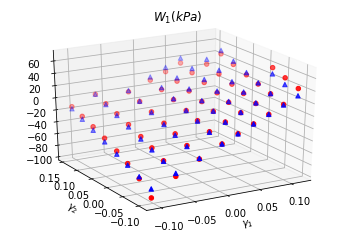

In [607]:
fig_ls_data = plt.figure()
ax = fig_ls_data.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
ax.scatter(X,Y,Zfit, c='b', marker='^')
ax.view_init(elev=25., azim=240)
ax.set_title(r'$W_1 (kPa)$')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_2$')
plt.savefig(infiles[0][:-4]+'ls_W1scatter.png',dpi=500,bbox_inches='tight')
plt.show()

##### Plot for W2

In [617]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in ls_datapoints:
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W2[i])
########################################
# Compute the fitted surface
Zfit = np.zeros(len(X))
for i in range(len(X)):
    Zfit[i] = responseW2(X[i], Y[i], 0.0, ls_parms_val, ls_terms)


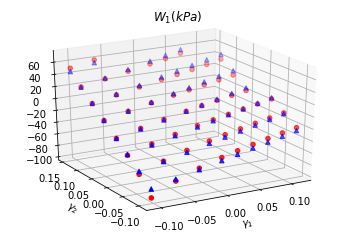

In [618]:
fig_ls_data = plt.figure()
ax = fig_ls_data.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
ax.scatter(X,Y,Zfit, c='b', marker='^')
ax.view_init(elev=25., azim=240)
ax.set_title(r'$W_1 (kPa)$')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_2$')
plt.savefig(infiles[0][:-4]+'ls_W2scatter.png',dpi=500,bbox_inches='tight')
plt.show()

##### Plot for W3

In [627]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in ls_datapoints:
    if abs(gamma2[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma3[i])
        Z.append(W3[i])
########################################
# Compute the fitted surface
Zfit = np.zeros(len(X))
for i in range(len(X)):
    Zfit[i] = responseW3(X[i], 0.0, Y[i], ls_parms_val, ls_terms)


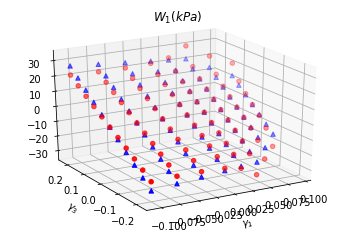

In [629]:
fig_ls_data = plt.figure()
ax = fig_ls_data.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
ax.scatter(X,Y,Zfit, c='b', marker='^')
ax.view_init(elev=25., azim=240)
ax.set_title(r'$W_1 (kPa)$')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_3$')
plt.savefig(infiles[0][:-4]+'ls_W3scatter.png',dpi=500,bbox_inches='tight')
plt.show()

### Post processing to remove the toe region

In [651]:
hs_vec_b = np.zeros(Wvector.size)
####
# Computes the Wvector data while removing the low stress component
for i in range(Wvector.size):
    hs_vec_b[i] = Wvector[i] - Wtensor[i,ls_terms].dot(ls_parms_val)

In [ ]:
Wtensor[:,range(7,key[4])].dot(np.array([ -2.41347656e+02,   2.08339874e+05,  -1.21878907e+07,
         2.92811903e+08,  -2.48100234e+09,  -3.59584996e+02,
         3.24851659e+04,  -1.05669256e+06,   3.19959568e+07,
        -2.05029224e+08,  -2.00493513e+09,   0.00000000e+00,
         0.00000000e+00,  -1.89429328e+06,   1.50270830e+08,
        -4.35166407e+09,   4.39608973e+10,   7.56105835e+03,
        -7.56270252e+04,   1.88258891e+05,  -2.73097288e+08,
         3.06804293e+09,  -2.69890200e+09,   4.03614135e+04,
         1.57206037e+05,   2.06380407e+07,   0.00000000e+00,
         0.00000000e+00])) - hs_vec_b

## Define the optimization problem

### Define the objective function

In [ ]:
def obj_f(const, degrees):
#     sse = np.log(np.abs(Wtensor[:,degrees].dot(const) - Wvector) + 1)
    sse = Wtensor[:,degrees].dot(const) - hs_vec_b
    return np.dot(sse,sse)




def obj_f_jac(const, degrees):
    jac = np.zeros(degrees.size)
    for i in range(degrees.size):
        jac[i] = 2*((Wtensor[:,degrees].dot(const) - hs_vec_b).dot(Wtensor[:,degrees[i]]))
    return jac

### Define the constraint functions

In [ ]:
def psi_1(i, degrees, x):
    return rW_tensor_1[i,degrees].dot(x)

def psi_2(i, degrees, x):
    return rW_tensor_2[i,degrees].dot(x)

def psi_3(i, degrees, x):
    return rW_tensor_3[i,degrees].dot(x)

def psi_4(i, degrees, x):
    return rW_tensor_4[i,degrees].dot(x)

def psi_5(i, degrees, x):
    return rW_tensor_5[i,degrees].dot(x)

def psi_6(i, degrees, x):
    return rW_tensor_6[i,degrees].dot(x)

In [ ]:
def constraint1(i, degrees, x):
    return psi_1(i, degrees, x)


def constraint2(i, degrees, x):
    return psi_6(i, degrees, x)


def constraint3(i, degrees, x):
    return psi_4(i, degrees, x)


def constraint4(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    return w1*w6 - w3*w3


def constraint5(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    return w1*w4 - w2*w2


def constraint6(i, degrees, x):
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    return w6*w4 - w5*w5


def constraint7(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    return w1*( w4*w6 - w5*w5 ) - w3*( w3*w4 - w5*w2 ) + w2*( w3*w5 - w6*w2 )

In [ ]:
def cons1_jac(i, degrees, x):
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = d_psi_1(i, degrees, j)
    return jacob


def cons2_jac(i, degrees, x):
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = d_psi_6(i, degrees, j)
    return jacob


def cons3_jac(i, degrees, x):
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = d_psi_4(i, degrees, j)
    return jacob


def cons4_jac(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = w6*d_psi_1(i, degrees, j) + w1*d_psi_6(i, degrees, j) - 2* w3*d_psi_3(i, degrees, j)
    return jacob


def cons5_jac(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = w4*d_psi_1(i, degrees, j) + w1*d_psi_4(i, degrees, j) - 2*w2*d_psi_2(i, degrees, j)
    return jacob


def cons6_jac(i, degrees, x):
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = w4*d_psi_6(i, degrees, j) + w6*d_psi_4(i, degrees, j) - 2* w5*d_psi_5(i, degrees, j)
    return jacob


def cons7_jac(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = (( w4*w6 - w5*w5 )*d_psi_1(i, degrees, j) + w1*w4*d_psi_6(i, degrees, j) 
                    + w1*w6*d_psi_4(i, degrees, j) - 2*w1*w5*d_psi_5(i, degrees, j)
                    - 2*w3*w4*d_psi_3(i, degrees, j) + w5*w2*d_psi_3(i, degrees, j)
                    - w3*w3*d_psi_4(i, degrees, j) + w3*w2*d_psi_5(i, degrees, j) + w3*w5*d_psi_2(i, degrees, j)
                    + w3*w5*d_psi_2(i, degrees, j) - 2*w6*w2*d_psi_2(i, degrees, j)
                    + w2*w5*d_psi_3(i, degrees, j) + w2*w3*d_psi_5(i, degrees, j) - w2*w2*d_psi_6(i, degrees, j)
                   )
    return jacob




## Forward Selection: Model enhancement

In [638]:
lb = np.full(index.size, -np.inf)
ub = np.full(index.size, np.inf)

for i in cons_positions:
    lb[i] = 0
    
    

In [668]:
res_forward = [0 for i in range(key.size)]
cost_forward = [0 for i in range(key.size)]


for i in range(key.size):
    testlist = range(3,key[i])
    res_forward[i] = lsq_linear(Wtensor[:,index[testlist]], hs_vec_b, \
                          bounds=(lb[testlist], ub[testlist]), \
                          method='bvls', lsmr_tol='auto', max_iter=10000, verbose=2)
    cost_forward[i] = res_forward[i].cost

The unconstrained solution is optimal.
Final cost 6.1851e+07, first-order optimality 2.41e-11
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         5.1094e+07                                    6.99e+01    
       1         5.1084e+07      9.61e+03       3.70e+04       1.10e-10    
       2         5.1084e+07      0.00e+00       0.00e+00       1.10e-10    
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 5.1094e+07, final cost 5.1084e+07, first-order optimality 1.10e-10.
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         4.0102e+07                                    7.45e+03    
       1         3.0575e+07      9.53e+06       5.03e+05       7.41e-10    
       2         3.0575e+07      0.00e+00       0.00e+00       7.41e-10    
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 4.0102e+07, final cost 3.0575e+07,

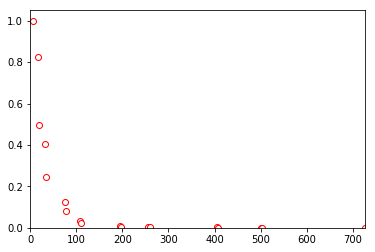

In [663]:
plt.plot(key, cost_forward/cost_forward[0],'ro',markerfacecolor='white')
plt.axis([0, key.max(), 0, 1.05])
plt.savefig('forwardselectionresult.png',dpi=500,bbox_inches='tight')
plt.show()

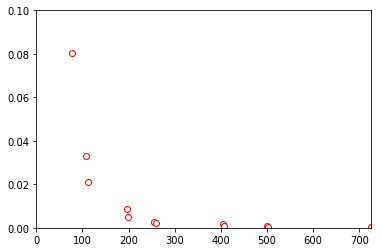

In [664]:
plt.plot(key, cost_forward/cost_forward[0],'ro',markerfacecolor='white')
plt.axis([0, key.max(), 0, 0.1])
plt.savefig('forwardselectionzoomed.png',dpi=500,bbox_inches='tight')
plt.show()

In [665]:
key

array([  7,  18,  20,  32,  35,  75,  77, 108, 111, 196, 198, 256, 259,
       405, 407, 500, 503, 726])

In [667]:
nk = 10
key[nk]

198

## Model parameter covariance

### Compute the covariance matrix 

In [730]:
CovM = (Wtensor.T).dot(Wtensor)
CovM[0,0] = 1.0

trace = np.diag(np.divide(1.0, np.sqrt(CovM.diagonal())))

corM = trace.dot(CovM).dot(trace)

### Parameter fitness

In [951]:
max_parm_cor = 0.5

In [832]:
def parm_bestfit(i):
    return (Wvector.dot(Wtensor[:,i]))/(Wtensor[:,i].dot(Wtensor[:,i]))

########################################


# def parm_fitness(i):
#     bval = parm_bestfit(i)
#     eps = bval*Wtensor[:,i] - Wvector
#     return (eps.dot(eps))/(Wvector.dot(Wvector))

########################################

def parm_fitness(i):
    bval = parm_bestfit(i)
    eps = bval*Wtensor[:,i] - hs_vec_b
    return (eps.dot(eps))/(hs_vec_b.dot(hs_vec_b))

In [952]:
bestset = np.zeros(key.max())
for i in np.arange(7,key.max()):
    testvec = np.array(np.where(np.abs(corM[index[i],index]) > max_parm_cor)[0])
    testval = np.array([parm_fitness(i) for i in testvec])
    bestset[i] = testvec[ testval == testval.min()]

    
setunion = np.union1d(bestset,bestset[7:10])
setunion = setunion.astype(int)
setunion = np.setdiff1d(setunion, [0,1,2,3,4,5,6])
print(setunion.size)

21


In [953]:
for i in setunion:
    print(find_index(10, index[i]))

(2, 0, 2)
(3, 0, 0)
(0, 3, 0)
(2, 3, 0)
(0, 3, 2)
(2, 3, 2)
(3, 3, 2)
(4, 0, 0)
(1, 4, 0)
(1, 0, 4)
(2, 0, 4)
(3, 4, 0)
(3, 0, 4)
(2, 1, 4)
(4, 4, 0)
(4, 2, 2)
(1, 3, 4)
(4, 1, 4)
(7, 1, 0)
(8, 0, 2)
(1, 2, 8)


## Backwards Elimination: Model refinement

In [955]:
initiallist = setunion
removedlist = []
costlist = np.full(sortedpositions.size, np.inf)
costresults = []
parmresults = []
termresults = []
initialguess = np.zeros(keypositions[nk])
timecost = np.zeros((len(initiallist) - 4))
res = [[0 for j in range(max(initiallist)+1)] for i in range(len(initiallist))]

ImportError: No module named 'nlopt'

In [ ]:
def constraints_function(degrees):
    cons = (
            {'type': 'eq','fun' : lambda x: x[1] - x[2], 'jac':lambda x:isocons_jac(degrees, x)},
            {'type': 'ineq', 'fun': lambda x: x[1], 'jac' : lambda x: x1cons_jac(degrees, x)},
            {'type': 'ineq', 'fun': lambda x: x[2], 'jac' : lambda x: x2cons_jac(degrees, x)},
            {'type': 'ineq', 'fun': lambda x: x[3], 'jac' : lambda x: x3cons_jac(degrees, x)},
            {'type': 'ineq', 'fun': lambda x: x[1]*x[2]-x[0]*x[0], 'jac' : lambda x: toecons_jac(degrees, x)}
            )
    for i in range(ncons):
        cons += ({'type': 'ineq', 'fun': lambda x: constraint1(i, degrees, x), 
                  'jac' : lambda x: cons1_jac(i, degrees, x)}
                 ,)
#         cons += ({'type': 'ineq', 'fun': lambda x: constraint2(i, degrees, x),
#                   'jac' : lambda x: cons2_jac(i, degrees, x)}
#                  ,)
#         cons += ({'type': 'ineq', 'fun': lambda x: constraint3(i, degrees, x),
#                  'jac' : lambda x: cons3_jac(i, degrees, x)}
#                  ,)
        cons += ({'type': 'ineq', 'fun': lambda x: constraint4(i, degrees, x),
                  'jac' : lambda x: cons4_jac(i, degrees, x)}
                 ,)
#         cons += ({'type': 'ineq', 'fun': lambda x: constraint5(i, degrees, x),
#                   'jac' : lambda x: cons5_jac(i, degrees, x)}
#                  ,)
#         cons += ({'type': 'ineq', 'fun': lambda x: constraint6(i, degrees, x),
#                   'jac' : lambda x: cons6_jac(i, degrees, x)}
#                  ,)
        cons += ({'type': 'ineq', 'fun': lambda x: constraint7(i, degrees, x),
                  'jac' : lambda x: cons7_jac(i, degrees, x)}
                 ,)
    return cons

In [ ]:
def f(x, grad):
    if grad.size > 0:
        grad[:] = obj_f_jac(x, model_exp)
        global model_exp
        return obj_f(x, model_exp)

    
def c(result, x, grad):
    if grad.size > 0:
        global model_exp
        for i in range(ncons):
            result[3*i] = constraint1(i, model_exp, x)
            result[3*i + 1] = constraint4(i, model_exp, x)
            result[3*i + 2] = constraint7(i, model_exp, x)
            grad[3*i,:] = cons1_jac(i, model_exp, x)
            grad[3*i + 1,:] = cons4_jac(i, model_exp, x)
            grad[3*i + 2,:] = cons7_jac(i, model_exp, x)
    return 0
                 
            

In [ ]:
opt = nlopt.opt(nlopt.LD_MMA, n)
opt.set_min_objective(f)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_ftol_rel(tol)
opt.set_ftol_abs(0)
opt.set_xtol_rel(tol)
opt.set_xtol_abs(0)

opt.set_maxeval(0)
opt.set_maxtime(14400)



In [ ]:
for i in range(len(initiallist) -4):
    start = time.time()
    for j in initiallist[4:]:
        testlist = [k for k in initiallist if k!=j]
        res[i][j] = lsq_linear(Wtensor[:,sortedpositions[testlist]], Wvector, lsmr_tol='auto', max_iter=10000, verbose=0)
        costlist[j] = res[i][j].cost
    besti = costlist.argmin()
    initiallist.remove(besti)
    removedlist.append(besti)
    costresults.append(costlist[besti])
    parmresults.append(res[i][besti].x)
    termresults.append(np.array(initiallist))
    costlist[besti] = np.inf
    end = time.time()
    timecost[i] = end - start
    print(i)

## Examining the results

### Final parameters

### Quality of fit

### Convexity

### Advanced results

In [958]:
PYTHONPATH

NameError: name 'PYTHONPATH' is not defined

In [956]:
sys.path

['',
 '/Users/willwiz/anaconda/lib/python35.zip',
 '/Users/willwiz/anaconda/lib/python3.5',
 '/Users/willwiz/anaconda/lib/python3.5/plat-darwin',
 '/Users/willwiz/anaconda/lib/python3.5/lib-dynload',
 '/Users/willwiz/anaconda/lib/python3.5/site-packages',
 '/Users/willwiz/anaconda/lib/python3.5/site-packages/Sphinx-1.5.1-py3.5.egg',
 '/Users/willwiz/anaconda/lib/python3.5/site-packages/aeosa',
 '/Users/willwiz/anaconda/lib/python3.5/site-packages/setuptools-27.2.0-py3.5.egg',
 '/Users/willwiz/anaconda/lib/python3.5/site-packages/IPython/extensions',
 '/Users/willwiz/.ipython']